Predict Future Sales:

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month.

In [3]:
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
%matplotlib inline
tf.__version__

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'2.2.0-rc3'

In [0]:
#download data from kaggle : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data

File descriptions

sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.

test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.

items.csv - supplemental information about the items/products.

item_categories.csv  - supplemental information about the items categories.

shops.csv- supplemental information about the shops.

In [0]:
#Lets Load data in notebook

In [7]:
#mounting drive to colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Load data 

In [0]:
items = pd.read_csv("/content/drive/My Drive/google_colab/Predict_future_sales/items.csv")
item_categories = pd.read_csv("/content/drive/My Drive/google_colab/Predict_future_sales/item_categories.csv")
shops = pd.read_csv("/content/drive/My Drive/google_colab/Predict_future_sales/shops.csv")

In [9]:
print ("item : \n",items.head())
print ("\nitems_categories : \n",item_categories.head())
print ("\nshops : \n",shops.head())

item : 
                                            item_name  item_id  item_category_id
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0                40
1  !ABBYY FineReader 12 Professional Edition Full...        1                76
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2                40
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3                40
4        ***КОРОБКА (СТЕКЛО)                       D        4                40

items_categories : 
         item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

shops : 
                         shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"   

In [0]:
train_df = pd.read_csv("/content/drive/My Drive/google_colab/Predict_future_sales/sales_train.csv", parse_dates=['date'])

In [0]:
test_df = pd.read_csv("/content/drive/My Drive/google_colab/Predict_future_sales/test.csv")

In [12]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


Data fields

ID - an Id that represents a (Shop, Item) tuple within the test set

shop_id - unique identifier of a shop

item_id - unique identifier of a product

item_category_id - unique identifier of item category

item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

item_price - current price of an item

date - date in format dd/mm/yyyy

date_block_num - a consecutive month number, used for convenience. 
January 2013 is 0, February 2013 is 1,..., October 2015 is 33

item_name - name of item

shop_name - name of shop

item_category_name - name of item category

In [13]:
train_df.shape ,test_df.shape, shops.shape, items.shape

((2935849, 6), (214200, 3), (60, 2), (22170, 3))

In [14]:
# Join all files data and create 1 data frame
train_df = train_df.join(items, on='item_id', rsuffix='_')
train_df = train_df.join(shops, on='shop_id', rsuffix='_')
train_df = train_df.join(item_categories, on='item_category_id', rsuffix='_')
train_df.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_id_,item_category_id,shop_name,shop_id_,item_category_name,item_category_id_
0,2013-02-01,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),22154,37,"Ярославль ТЦ ""Альтаир""",59,Кино - Blu-Ray,37
1,2013-03-01,0,25,2552,899.0,1.0,DEEP PURPLE The House Of Blue Light LP,2552,58,"Москва ТРК ""Атриум""",25,Музыка - Винил,58


In [15]:
#drop duplicate columns 
train_df = train_df.drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)
train_df.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.0,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил


In [16]:
# test data 
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


Problem_statement: 

forecast the total amount of products sold in every shop in a month. 

2. Data Pre-processing & EDA


In [0]:
# how many shops and items/products are there in test data for them we need forcast model

In [18]:
train_shops = train_df['shop_id'].unique()
train_items = train_df['item_id'].unique()
test_shops = test_df['shop_id'].unique()
test_items = test_df['item_id'].unique()

print (len(train_shops), len(train_items),len(test_shops), len(test_items))

60 21807 42 5100


In [19]:

train_df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


In [0]:


# this columns are not important for futher analysis : item_name, shop_name, 	item_category_name
# we have item_category_id, item_is and shop_id which will take care of these 3 columns

In [21]:
#drop coluns 
train_db = train_df.drop(['item_name', 'shop_name', 'item_category_name'], axis=1)
train_db.shape

(2935849, 7)

Text(0.5, 1.0, 'total sale in a month')

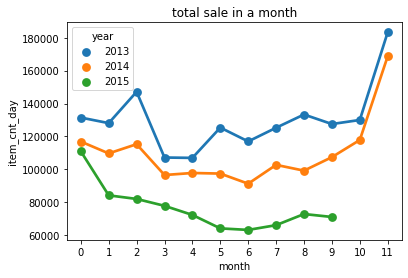

In [22]:
train_db['year'] = train_db['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_db['month'] = train_db['date_block_num'].apply(lambda x: (x % 12))
grouped = pd.DataFrame(train_db.groupby(['year','month'])['item_cnt_day'].sum().reset_index())
sns.pointplot(x='month', y='item_cnt_day', hue='year', data=grouped)
plt.title("total sale in a month")
#print(grouped.head())

Text(0.5, 1.0, 'item prices in a month')

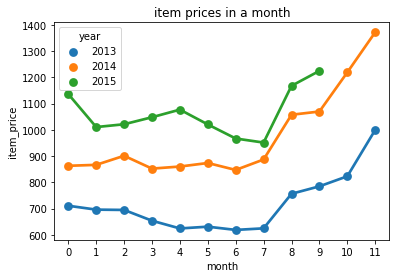

In [23]:
grouped = pd.DataFrame(train_db.groupby(['year','month'])['item_price'].mean().reset_index())
sns.pointplot(x='month', y='item_price', hue='year', data=grouped)
plt.title("item prices in a month")
#grouped.head()

from graph it's clear that prices and sales are incresing at the last month of year.

Sales and prices both increasing per year.

we have data till October 2015

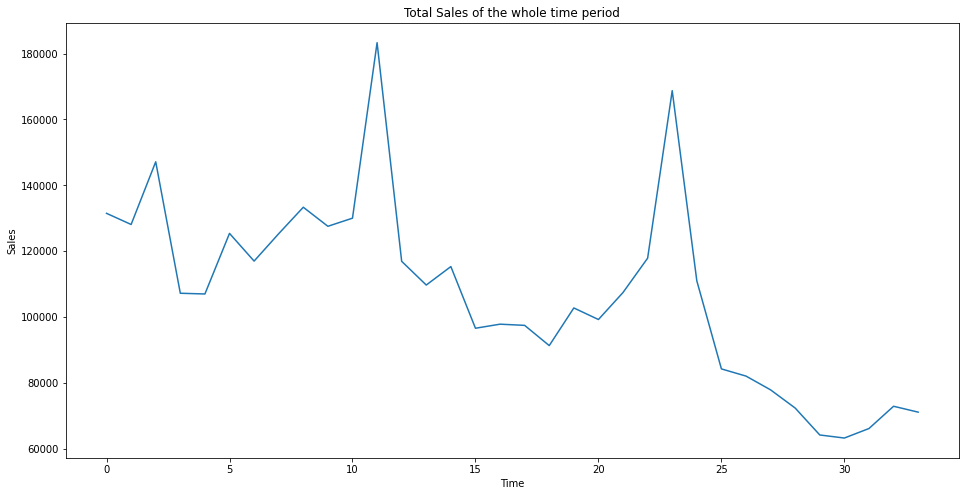

In [24]:
sales_pattern=train_db.groupby(["date_block_num"])["item_cnt_day"].sum()
plt.figure(figsize=(16,8))
plt.title('Total Sales of the whole time period')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(sales_pattern)

Sales is increasing , you can see 2 peak. these peak are the last month of every year. we don't have 2015 last 2 months data.

Text(0, 0.5, 'number of sales in a day')

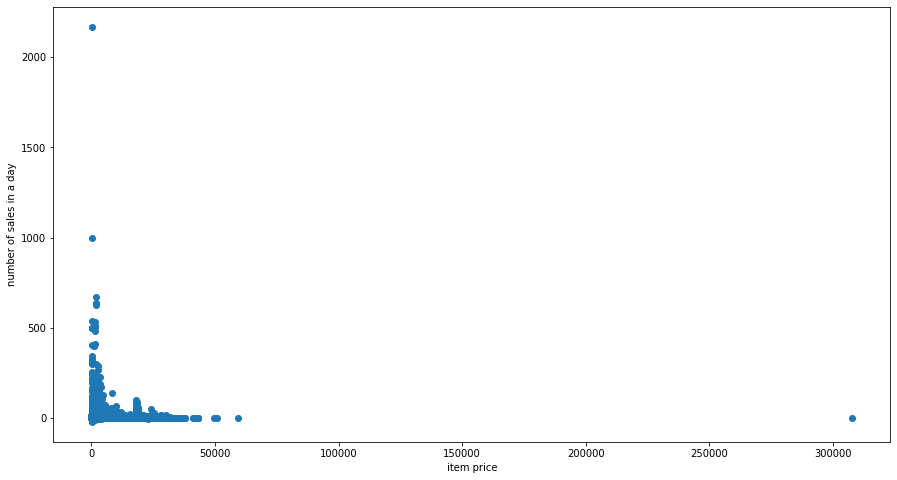

In [25]:
plt.figure(figsize=(15, 8))
plt.scatter(train_df['item_price'], train_df['item_cnt_day'])
plt.xlabel("item price")
plt.ylabel("number of sales in a day")

Outliers : 
item_price > 100k & sales > 2k

In [26]:
print (train_df.shape)
train_df = train_df[(train_df['item_cnt_day'] <= 2000)]
train_df = train_df[(train_df['item_price'] <= 100000)]
train_df.shape

(2935849, 10)


(2935847, 10)

In [27]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-05-01,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-06-01,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


date_block_num = has info of month and year , 0 mean jan,2013 and 33 means Oct,2015

month and year is  correlated with date_block_num, so we can keep date_block_num and remove month and year from dataset

similarely shop_id & item_id is correlated with price of item so we can keep shop_id and  item_id and remove item_price

item_category_id isnot important



Transform the data for modeling.

In [0]:
timeseries_data = pd.pivot_table(train_df, values='item_cnt_day', index=['shop_id', 'item_id'],columns=['date_block_num'], aggfunc=np.sum,fill_value=0).reset_index().rename_axis(None, axis=1)

In [29]:
timeseries_data.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0,30,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,31,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,32,6,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,33,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,35,1,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


let's generate test data with time series vectors based on shop_id and item_id from test_data file

In [30]:
test = test_df.drop(['ID'], axis=1)
print (timeseries_data.shape, test.shape)
test = pd.merge(test, timeseries_data, on = ['shop_id', 'item_id'], how = 'left') #will have NaN if shop and item d is not present in timeseries_data
print ("size of test data before droping nan rows: ", test.shape)
test = test.dropna() #let's remove nan we have have model trained on these id so it won't give right prediction
print  ("size of test data after droping nan rows: ", test.shape)
test.head()

(424123, 36) (214200, 2)
size of test data before droping nan rows:  (214200, 36)
size of test data after droping nan rows:  (111404, 36)


,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,5,5039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0
6,5,5041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0


In [0]:
#let's keep only month wise sale data and drop shop_id ad item_id
timeseries_data = timeseries_data.drop(['shop_id','item_id'],axis = 1)
test = test.drop(['shop_id', 'item_id'], axis=1)

In [32]:
timeseries_data.shape ,test.shape

((424123, 34), (111404, 34))

Since we are going to predict only for test data so we can train our model only for those shops and their items.

if we can train on all the timeseries_data then we can predict for all the shops and items in given timeseries_data.

so I recommnded to train on whole dataset 

But here I'm only going to train on only for shop_id and item_id which are in test data.

In [0]:
#if want to train on whole dataset then 
#train on timesieries_data and predict only for test data shop_id and item_id

#I am going to use only test data (0 to 32 columns for training and will test with 33rd (label) column)
#then will predict for nov,2015 and input will be test data (1 to 33 columns)
final_data = test

now we thave training and testind data.

Now let's convert them to train supervised learning model.

training:  we will use 0 to 32 columns as training features and 33 columns
as a label

testing: we will use 1 to 33 column as input and will predict for nov, 2015 (34 column) 

In [34]:
 X_train = final_data.iloc[:, :-1]
 y_train = final_data.iloc[:,-1:]
 X_test  = final_data.iloc[:,1:]
 X_train.shape, y_train.shape, X_test.shape

((111404, 33), (111404, 1), (111404, 33))

In [35]:
print (X_train.head())
print (y_train.head())
print (X_test.head())

    0    1    2    3    4    5    6   ...   26   27   28   29   30   31   32
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  1.0  1.0  3.0  1.0
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  3.0  2.0  0.0  1.0  3.0
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  3.0  0.0  0.0  0.0  1.0
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  3.0

[5 rows x 33 columns]
    33
0  0.0
2  1.0
3  0.0
5  1.0
6  2.0
    1    2    3    4    5    6    7   ...   27   28   29   30   31   32   33
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  1.0  1.0  3.0  1.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  3.0  2.0  0.0  1.0  3.0  1.0
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  3.0  0.0  0.0  0.0  1.0  1.0
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  3.0  2.0

[5 rows x 

I'll be creating validation (30k samples) data from time_series_data which is not in the test data


In [36]:
from sklearn.utils import shuffle
validation_data = shuffle(timeseries_data[~timeseries_data.isin(final_data)].dropna())
validation_data = validation_data.iloc[0:30000,:]
validation_data.shape

(30000, 34)

In [0]:
X_val = validation_data.iloc[:, :-1]
y_val = validation_data.iloc[:,-1:]

Input format for MLP

[samples, features]

In [38]:
print ("Input format for MLP")
print ("X_train shape: ", X_train.shape)
print ("X_valid shape: ", X_val.shape)
print ("y_train shape: ", y_train.shape)
print ("y_valid shape: ", y_val.shape)
print ("X_test  shape: ", X_test.shape)

Input format for MLP
X_train shape:  (111404, 33)
X_valid shape:  (30000, 33)
y_train shape:  (111404, 1)
y_valid shape:  (30000, 1)
X_test  shape:  (111404, 33)


Input format for CNN and RNN

[samples, timesteps, feature]

In [39]:
#input : [samples, timesteps, features]
#convert data into input format
X_train_timesteps = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_timesteps = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_timesteps = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print("Input format for CNN and RNN")
print ("X_train shape: ", X_train_timesteps.shape)
print ("X_valid shape: ", X_val_timesteps.shape)
print ("y_train shape: ", y_train.shape)
print ("y_valid shape: ", y_val.shape)
print ("X_test  shape: ", X_test_timesteps.shape)

Input format for CNN and RNN
X_train shape:  (111404, 33, 1)
X_valid shape:  (30000, 33, 1)
y_train shape:  (111404, 1)
y_valid shape:  (30000, 1)
X_test  shape:  (111404, 33, 1)


Now data set is ready for modeling 

In [0]:
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout,concatenate
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling1D, Embedding,TimeDistributed
from tensorflow.keras.layers import LSTM, Bidirectional, GRU
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler
from tensorflow.keras.regularizers import l2

In [0]:
def scheduler(epoch):
  if epoch < 10:
    return 0.01
  else:
    return 0.01 * tf.math.exp(0.1 * (10 - epoch))
lr_scheduler = LearningRateScheduler(scheduler) 
# This callback will stop the training when there is no improvement in
# the validation loss for 50 consecutive epochs and will save best weights
callback = EarlyStopping(monitor='val_loss', patience=30,restore_best_weights=True,mode="min") 

#1. MLP as regressor

In [0]:
#input : [sample , features] , does not care about time dependencies

In [0]:
def MLP():
  model = Sequential()
  model.add(Dense(100,activation='relu',input_dim= 33))
  model.add(Dense(100, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(200, activation='relu'))
  model.add(Dense(200, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(50, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-2), loss='mse')
  print (model.summary())
  return model

In [43]:
model = MLP()
model.fit(X_train,y_train,validation_data=(X_val, y_val), callbacks=[callback,lr_scheduler], epochs=100, batch_size=1000, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               3400      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               2

In [44]:
y_predicted = model.predict(X_test, verbose=1, batch_size=1000)

112/112 [==============================] - 0s 1ms/step


In [45]:
#let's cpmapre on validation set how it's predicting 
y_pred_val = model.predict(X_val, verbose=1, batch_size=1000)

30/30 [==============================] - 0s 1ms/step


# 2. CNN as Regressor

In [0]:
def CNN():
  model = Sequential()
  model.add(Conv1D(32, kernel_size=3,activation='relu',input_shape=(33,1)))
  model.add(Conv1D(64, kernel_size=3,activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.5))
  model.add(Conv1D(128, kernel_size=3,activation='relu'))
  model.add(Conv1D(256, kernel_size=3,activation='relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(128, kernel_size=3,activation='relu'))
  model.add(Conv1D(64, kernel_size=3,activation='relu'))
  model.add(Flatten())
  model.add(Dense(50))
  model.add(Dense(1))
  print (model.summary())
  model.compile(optimizer='rmsprop', loss='mse')
  return model

In [47]:
model = CNN()
model.fit(X_train_timesteps,y_train,validation_data=(X_val_timesteps, y_val), callbacks=[callback,lr_scheduler], epochs=100, batch_size=1000, verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 31, 32)            128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 29, 64)            6208      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 64)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 256)           98560     
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 256)          

#Why Validation loss is less than trainin loss
reasons:

1. Regularization applied during training, but not during validation/testing.

2. Training loss is measured during each epoch while validation loss is measured after each epoch.

3. The validation set may be easier than the training set (or there may be leaks).

link : https://www.pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/



#3. LSTM 

It will learn patterns from long sequences.

In [0]:
def LSTM_Model():
  model = Sequential()
  model.add(LSTM(100,return_sequences=True,input_shape=(33,1))) #return_sequences=True
  model.add(LSTM(100,dropout=0.2,return_sequences=True))
  model.add(LSTM(100,dropout=0.2,return_sequences=True))
  model.add(LSTM(100,dropout=0.2))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.compile(optimizer='rmsprop', loss='mse')
  print(model.summary())
  return model

In [49]:
model = LSTM_Model()
model.fit(X_train_timesteps,y_train,validation_data=(X_val_timesteps, y_val), callbacks=[callback,lr_scheduler], epochs=100, batch_size=1000, verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 33, 100)           40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 33, 100)           80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 33, 100)           80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 282,101
Trainable params: 282,101
Non-trainable params: 0
________________________________________________

In [52]:
y_pred_lstm = model.predict(X_test_timesteps, verbose=1, batch_size=1000)

112/112 [==============================] - 2s 20ms/step


#4. CNN + LSTM 

Input Shape = [sampes, subsequences, timesteps, features]


In [42]:
subseq = 3
new_timesteps =  X_train_timesteps.shape[1] // subseq
X_train_subseq = X_train_timesteps.reshape((X_train_timesteps.shape[0],subseq, new_timesteps,1))
X_val_subseq =   X_val_timesteps.reshape((X_val_timesteps.shape[0],subseq, new_timesteps,1))
X_test_subseq =  X_test_timesteps.reshape((X_test_timesteps.shape[0],subseq, new_timesteps,1)) 
print (X_train_subseq.shape, X_val_subseq.shape, X_test_subseq.shape)

(111404, 3, 11, 1) (30000, 3, 11, 1) (111404, 3, 11, 1)


In [0]:
def CNN_LSTM():
  model = Sequential()
  model.add(TimeDistributed(Conv1D(64, kernel_size= 1, activation='relu'),input_shape = (None, 11,1)))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(100,activation='relu',kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
  model.add(Dense(50,activation='relu',kernel_regularizer=l2(0.01)))
  model.add(Dense(1))
  model.compile(optimizer='rmsprop', loss='mse')
  print(model.summary())
  return model   

In [62]:
CNN_LSTM_Model = CNN_LSTM()
CNN_LSTM_Model.fit(X_train_subseq,y_train,validation_data=(X_val_subseq, y_val), callbacks=[callback,lr_scheduler], epochs=100, batch_size=1000, verbose=1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, None, 11, 64)      128       
_________________________________________________________________
time_distributed_22 (TimeDis (None, None, 5, 64)       0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, None, 320)         0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               168400    
_________________________________________________________________
dense_12 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 173,629
Trainable params: 173,629
Non-trainable params: 0
________________________________________________

In [0]:
# reference : 
#https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/